In [ ]:
# 1. Import libraries
import ast 
import pandas as pd
from datasets import load_dataset 
import matplotlib.pyplot as plt
import seaborn as sns 

# 2. Load a dataset
ds = load_dataset("lukebarousse/data_jobs")  

df_copy = ds['train'].to_pandas()  

df = df_copy.copy()  


# 3. Data cleaning
df['job_posted_date'] = pd.to_datetime(df.job_posted_date)  

df['job_skills'] = df['job_skills'].apply(
    lambda skills: ast.literal_eval(skills) if pd.notna(skills) else []
)

c:\Users\User\anaconda3\envs\analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


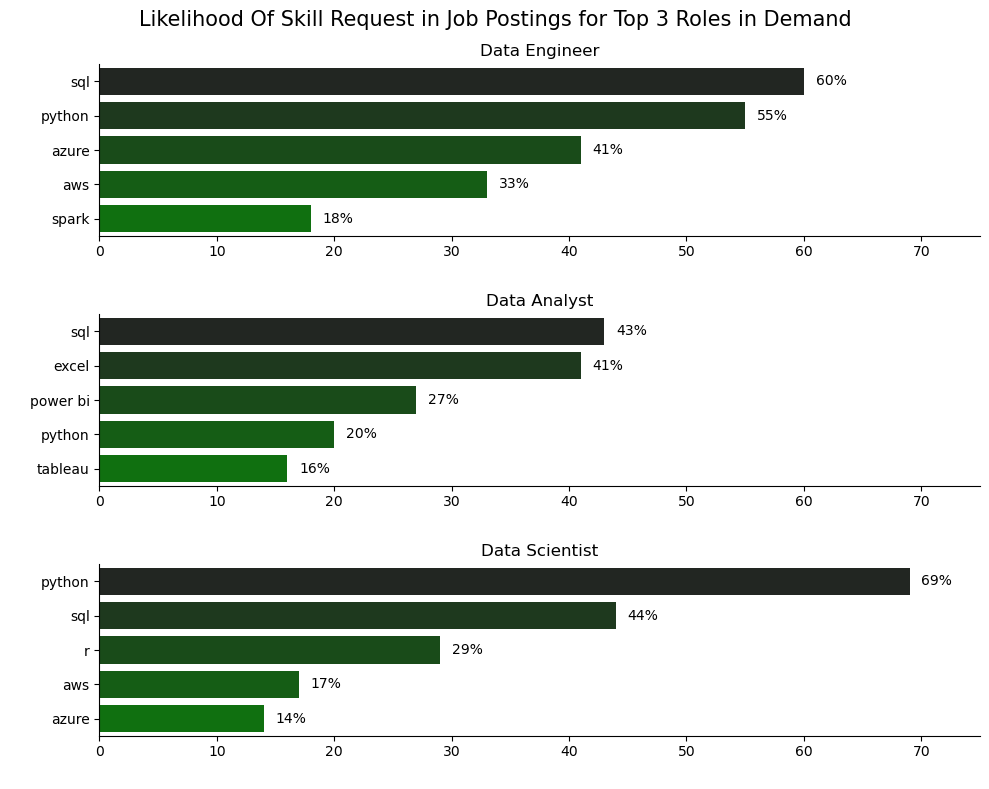

In [8]:
# 1. Filter dataset for a specific country
df_uk = df[df['job_country'] == df['job_country'].value_counts().index[2]]  
# Selects the country that is third most common in the dataset

# 2. Count jobs by title
job_count = df_uk['job_title_short'].value_counts()  
top_3 = job_count.head(3).index  # Get the top 3 most frequent job titles
job_df = job_count.reset_index()  # Convert counts to a DataFrame
job_df.columns = ['job_title_short', 'count']  # Rename columns for merging

# 3. Prepare skills data
df_exp = df_uk.explode(column='job_skills')  
# Explodes the job_skills list into separate rows

df_grouped = df_exp.groupby(['job_title_short', 'job_skills']).size()  
# Count occurrences of each skill per job title

df_grouped = df_grouped.reset_index(name='skill_count').sort_values(by='skill_count', ascending=False)  
# Reset index and sort by frequency

# 4. Merge with total job counts to calculate percentages
df_final = df_grouped.merge(job_df, how='left', on='job_title_short')  
df_final['pct'] = (df_final['skill_count'] / df_final['count'] * 100).round()  
df_final.drop(columns=['skill_count', 'count'], inplace=True)  
# Calculate the percentage of postings requesting each skill and remove extra columns

# 5. Plot the top skills for the top 3 job titles
fig, ax = plt.subplots(3, 1, figsize=(10, 8))  
palette = sns.color_palette("dark:g_r", n_colors=5)

for i, title in enumerate(top_3):
    df_plot = df_final[df_final['job_title_short'] == title].head(5)  
    # Take top 5 skills for this job title

    sns.barplot(
        data=df_plot, 
        y='job_skills', 
        x='pct', 
        ax=ax[i], 
        hue='pct', 
        palette=palette
    )

    # Customize plot
    ax[i].set_title(title)
    ax[i].set_ylabel(' ')
    ax[i].set_xlabel(' ')
    ax[i].set_xlim(0, 75)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].legend().set_visible(False)

    # Add percentage labels to bars
    for id, value in enumerate(df_plot['pct']):
        ax[i].text(value + 1, id, f'{int(value)}%', va='center')

# 6. Add overall figure title and adjust layout
fig.suptitle('Likelihood Of Skill Request in Job Postings for Top 3 Roles in Demand', fontsize=15)
fig.tight_layout()
plt.show()